# Imports

In [126]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import interpolate
from sklearn import cluster
from sklearn import metrics

# Functions

In [2]:
# function to load each data sheet of pSTAT experiments (each sheet is a separate experiment)
# inputs: filename = string with name of file, measure = string of STAT (e.g., 'pSTAT3')
# outputs: var_names = list of sheetnames, data_dfs = list of dataframes each with an experiment, exp_dates = list of experiment dates
def load_sheets(filename,measure):
    sheets = pd.ExcelFile(filename).sheet_names
    var_names = [s + ('_' + measure) for s in sheets]
    data_dfs = []
    exp_dates = []
    
    for i in sheets:
        # ignore last column since it has the date of experiment 
        data_dfs.append(pd.read_excel(filename,header=0,sheet_name=i,index_col=0).iloc[:,0:-1])
        exp_dates.append(pd.read_excel(filename,header=0,sheet_name=i,index_col=0).columns[-1])
    
    return var_names,data_dfs,exp_dates

In [5]:
# function to shift each experiment to start at 0 (we assume no pSTAT at 0 minutes)
# input: list of pandas dataframes 
# output: list of 0 shifted pandas dataframes 
def shift(df_list):
    shift_df_list = []
    for i in range(len(df_list)):
        df = df_list[i]
        shift_df = df - df.iloc[0,:]
        shift_df[shift_df < 0] = 0 # set negative values to 0 (prevents negative phosphorylation values)
        shift_df_list.append(shift_df)
        
    return shift_df_list

In [51]:
# function to find average and standard deviation of each condition and interpolate if missing time points exist
# input: df_list = list of pandas dataframes, stim = string for stimulation i.e. 'il6_1_il10_1'
# output: avg_out = numpy array with timepoints (column 1), average pSTAT value (column 2), and standard deviation (column 3)
def get_avg_cond(df_list,stim):
    # get all the possible time points
    times = []
    for i in range(len(df_list)):
        times+=list(df_list[i].index)
    times = np.unique(times)
    
    # array to store results
    avg_out = np.zeros((len(times),3))
    
    # get avg. and std. across experiments
    temp = np.ones((len(times),len(df_list))) * np.nan
    for i in range(len(df_list)):
        try: # check if this experiment has the stim. of interest
            check = df_list[i][stim]
            try: # check if the stim. was measured at every time point
                temp[:,i] = check.loc[times]
            except:
                # interpolate
                f = interpolate.interp1d(check.index,check,fill_value='extrapolate')
                temp[:,i] = f(times)
        except:
            pass
        
    # save times, means, and stds to numpy array
    avg_out[:,0] = times
    avg_out[:,1] = np.nanmean(temp,axis=1)
    avg_out[:,2] = np.nanstd(temp,axis=1)
    
    return avg_out

In [124]:
# function to cluster pSTAT trajectories
# inputs:
# outputs: 
def km_clus(data_df,k):
    # assign clusters
    kmeans = cluster.KMeans(n_clusters=k)
    assign = kmeans.fit_predict(data_df.T)

    # silhouette scores
    labels = kmeans.labels_
    s = metrics.silhouette_score(data_df.T, labels, metric='euclidean')

    return assign, s

# Main Script

In [56]:
# load data files
pSTAT3_names_list,pSTAT3_df_list,pSTAT3_date_list = load_sheets('Data/pSTAT_experimental_data/pSTAT3_pooled_data.xlsx','pSTAT3')
pSTAT1_names_list,pSTAT1_df_list,pSTAT1_date_list = load_sheets('Data/pSTAT_experimental_data/pSTAT1_pooled_data.xlsx','pSTAT1')

print(len(pSTAT3_df_list), 'pSTAT3 experiments')
print(len(pSTAT1_df_list), 'pSTAT1 experiments')

# shift pSTAT data to start at 0 MFI at 0 min
pSTAT3_shift_list = shift(pSTAT3_df_list)
pSTAT1_shift_list = shift(pSTAT1_df_list)

# normalize each experiment to IL-6 10 ng/ml 20 min value 
pSTAT3_norm_exp_df_list = [(pSTAT3_shift_list[i] / pSTAT3_shift_list[i].loc[20]['il6_10']) for i in range(len(pSTAT3_shift_list))]
pSTAT1_norm_exp_df_list = [(pSTAT1_shift_list[i] / pSTAT1_shift_list[i].loc[20]['il6_10']) for i in range(len(pSTAT1_shift_list))]

9 pSTAT3 experiments
5 pSTAT1 experiments


In [121]:
# get sample means and stds across experiments
stim_conds = np.unique(np.concatenate([pSTAT3_norm_exp_df_list[i].columns for i in range(len(pSTAT3_norm_exp_df_list))]))

mean_pSTAT3_data_for_clus = np.squeeze([get_avg_cond(pSTAT3_norm_exp_df_list,i)[:,1] for i in stim_conds]).T
mean_pSTAT1_data_for_clus = np.squeeze([get_avg_cond(pSTAT1_norm_exp_df_list,i)[:,1] for i in stim_conds]).T
std_pSTAT3_data_for_clus = np.squeeze([get_avg_cond(pSTAT3_norm_exp_df_list,i)[:,2] for i in stim_conds]).T
std_pSTAT1_data_for_clus = np.squeeze([get_avg_cond(pSTAT1_norm_exp_df_list,i)[:,2] for i in stim_conds]).T


# combine pSTAT3 and pSTAT1 and make dataframe
mean_times = np.squeeze([get_avg_cond(pSTAT3_norm_exp_df_list,i)[:,0] for i in stim_conds]).T[:,0:2].astype(int)

mean_pSTAT_data_for_clus = np.concatenate([mean_pSTAT3_data_for_clus,mean_pSTAT1_data_for_clus])
mean_pSTAT_data_for_clus_df = pd.DataFrame(mean_pSTAT_data_for_clus)
mean_pSTAT_data_for_clus_df.index = np.row_stack([mean_times[:,0],mean_times[:,1]]).reshape(-1,)
mean_pSTAT_data_for_clus_df.columns = stim_conds

std_pSTAT_data_for_clus = np.concatenate([std_pSTAT3_data_for_clus,std_pSTAT1_data_for_clus])
std_pSTAT_data_for_clus_df = pd.DataFrame(std_pSTAT_data_for_clus)
std_pSTAT_data_for_clus_df.index = np.row_stack([mean_times[:,0],mean_times[:,1]]).reshape(-1,)
std_pSTAT_data_for_clus_df.columns = stim_conds


2 Clusters: 0.4912187821110247


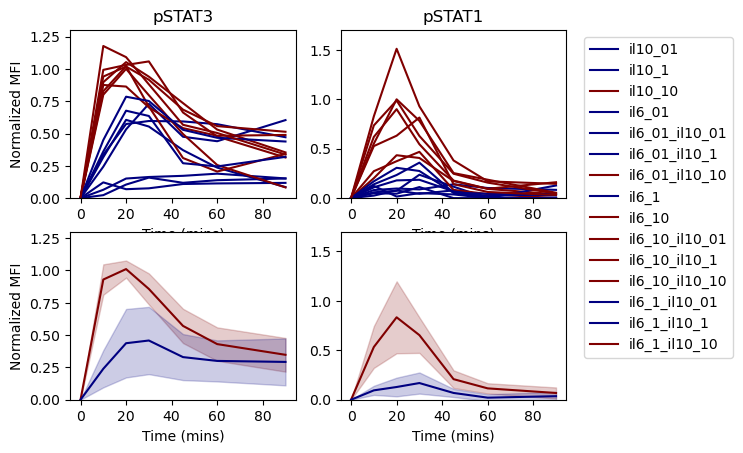

3 Clusters: 0.4892111543033685


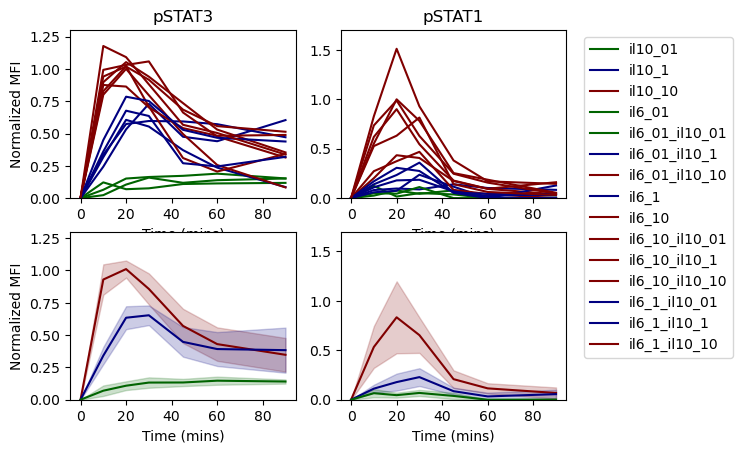

4 Clusters: 0.47596057819050525


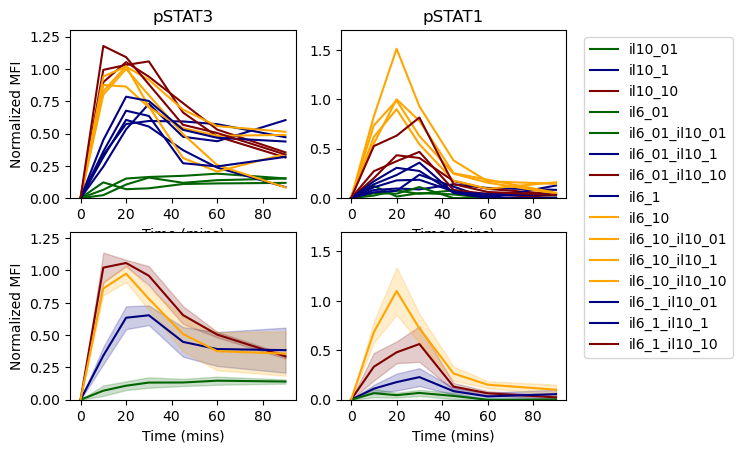

5 Clusters: 0.46366751796687705


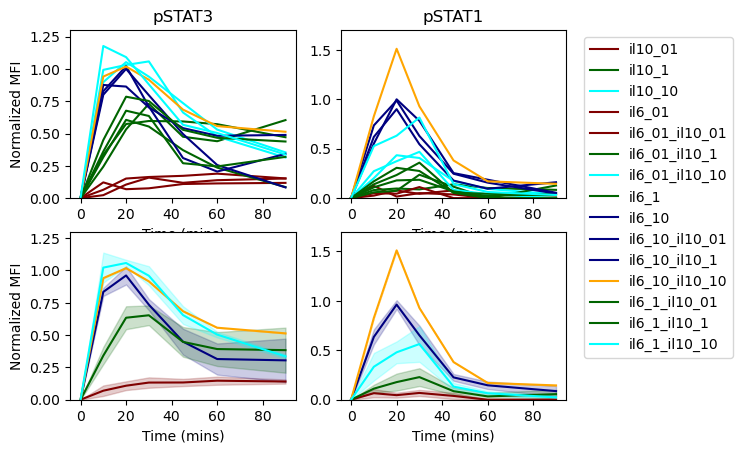

6 Clusters: 0.40527488689174473


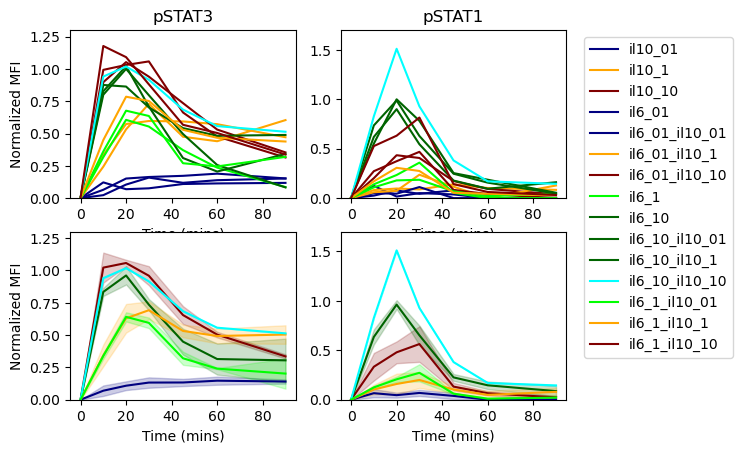

7 Clusters: 0.3900834505816591


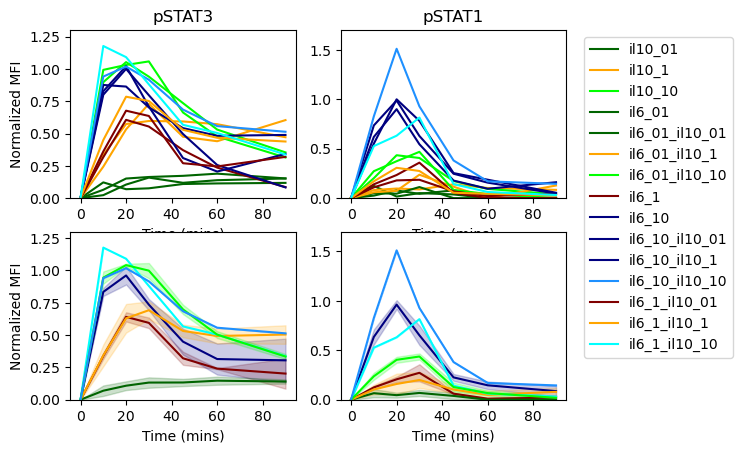

8 Clusters: 0.352772225123671


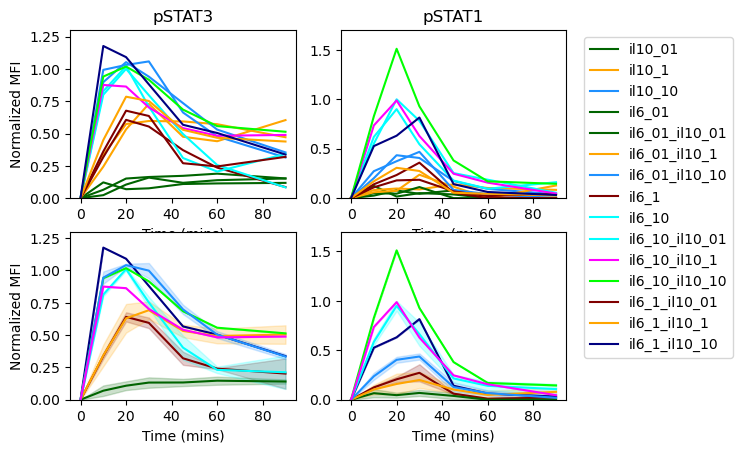

9 Clusters: 0.32868831173622937


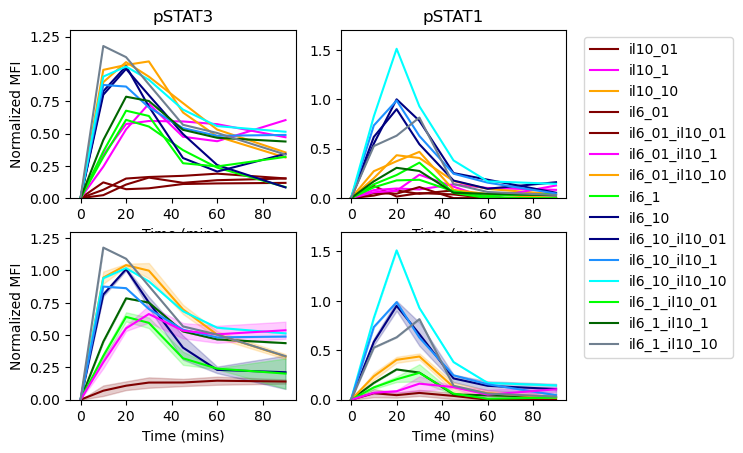

10 Clusters: 0.3139163749104052


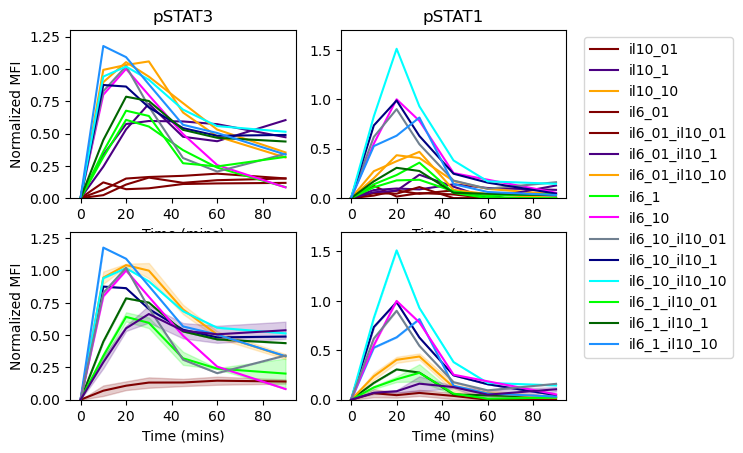

In [154]:
# cluster cytokine stimulations that produce similar pSTAT3 and pSTAT1 trends
clus_c = ['maroon','navy','darkgreen','orange','cyan','lime','dodgerblue','fuchsia','slategray','indigo']

# try different k's (2-10)
for k in range(2,11):
    stat_clus,s_score = km_clus(mean_pSTAT_data_for_clus_df,int(k))
    print(k, 'Clusters:', s_score)
    
    # plot clusters with individual trajectories
    for i in range(mean_pSTAT3_data_for_clus.shape[1]):
        # plot pSTAT3
        plt.subplot(2, 2, 1)
        plt.plot(mean_times[:,0], mean_pSTAT3_data_for_clus[:,i], color=clus_c[stat_clus[i]])
        plt.xlabel('Time (mins)')
        plt.ylabel('Normalized MFI')
        plt.title('pSTAT3')
        plt.ylim([0,1.3])
        
        # plot pSTAT1
        plt.subplot(2, 2, 2)
        plt.plot(mean_times[:,0], mean_pSTAT1_data_for_clus[:,i], color=clus_c[stat_clus[i]])
        plt.xlabel('Time (mins)')
        plt.title('pSTAT1')
        plt.ylim([0,1.7])
        plt.legend(mean_pSTAT_data_for_clus_df.columns,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
    # plot cluster ranges for groups of trajectories
    for i in range(k):
        ind = np.where(stat_clus == i)[0]
        
        # plot pSTAT3
        plt.subplot(2, 2, 3)
        plt.plot(mean_times[:,0],np.mean(mean_pSTAT3_data_for_clus[:,ind],axis=1),color=clus_c[i])
        plt.fill_between(mean_times[:,0], np.mean(mean_pSTAT3_data_for_clus[:,ind],axis=1) - np.std(mean_pSTAT3_data_for_clus[:,ind],axis=1), np.mean(mean_pSTAT3_data_for_clus[:,ind],axis=1) + np.std(mean_pSTAT3_data_for_clus[:,ind],axis=1), color=clus_c[i],alpha=0.2)
        plt.xlabel('Time (mins)')
        plt.ylabel('Normalized MFI')
        plt.ylim([0,1.3])
        
        # plot pSTAT1 
        plt.subplot(2, 2, 4)
        plt.plot(mean_times[:,0],np.mean(mean_pSTAT1_data_for_clus[:,ind],axis=1),color=clus_c[i])
        plt.fill_between(mean_times[:,0], np.mean(mean_pSTAT1_data_for_clus[:,ind],axis=1) - np.std(mean_pSTAT1_data_for_clus[:,ind],axis=1), np.mean(mean_pSTAT1_data_for_clus[:,ind],axis=1) + np.std(mean_pSTAT1_data_for_clus[:,ind],axis=1), color=clus_c[i],alpha=0.2)
        plt.xlabel('Time (mins)')
        plt.ylim([0,1.7])
    
    plt.show()